## Part 2a: generate disv properties

In [1]:
import sys, json, os ## Org
import rasterio, flopy ## Org
import numpy as np ## Org
import matplotlib.pyplot as plt ## Org
import geopandas as gpd ## Org
from mf6Voronoi.meshProperties import meshShape ## Org
from shapely.geometry import MultiLineString ## Org

c:\Users\saulm\anaconda3\Lib\site-packages\pyvista\examples\downloads.py:93: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  Path(USER_DATA_PATH, exist_ok=True).mkdir()
c:\Users\saulm\anaconda3\Lib\site-packages\pyvista\examples\downloads.py:98: UserWarning: Unable to access C:\Users\saulm\AppData\Local\pyvista_3\pyvista_3\Cache. Manually specify the PyVistaexamples cache with the PYVISTA_USERDATA_PATH environment variable.
  warnings.warn(


In [2]:
# open the json file
with open('../json/disvDict.json') as file: ## <==== updated
    gridProps = json.load(file) ## Org

In [3]:
cell2d = gridProps['cell2d']           #cellid, cell centroid xy, vertex number and vertex id list
vertices = gridProps['vertices']       #vertex id and xy coordinates
ncpl = gridProps['ncpl']               #number of cells per layer
nvert = gridProps['nvert']             #number of verts
centroids=gridProps['centroids']       #cell centroids xy 

## Part 2b: Model construction and simulation

In [4]:
#Extract dem values for each centroid of the voronois
src = rasterio.open('../Rst/clipDem100m.tif')  ## <==== updated
elevation=[x for x in src.sample(centroids)] ## Org

In [5]:
nlay = 5   ## Org

mtop=np.array([elev[0] for i,elev in enumerate(elevation)]) ## Org
zbot=np.zeros((nlay,ncpl)) ## Org


AcuifInf_Bottom = 100 ## <==== updated
zbot[0,] = mtop - 20 ## Org
zbot[1,] = AcuifInf_Bottom + (0.85 * (mtop - AcuifInf_Bottom)) ## Org
zbot[2,] = AcuifInf_Bottom + (0.70 * (mtop - AcuifInf_Bottom)) ## Org
zbot[3,] = AcuifInf_Bottom + (0.50 * (mtop - AcuifInf_Bottom)) ## Org
zbot[4,] = AcuifInf_Bottom ## Org

### Create simulation and model

In [6]:
# create simulation
simName = 'mf6Sim' ## Org
modelName = 'mf6Model' ## Org
modelWs = '../modelFiles' ## <==== updated
sim = flopy.mf6.MFSimulation(sim_name=modelName, version='mf6', ## Org
                             exe_name='../bin/mf6.exe', ## Org
                             sim_ws=modelWs) ## Org

In [7]:
# create tdis package
tdis_rc = [(1000.0, 1, 1.0)] ## Org
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', ## Org
                             perioddata=tdis_rc) ## Org

In [8]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, ## Org
                           modelname=modelName, ## Org
                           save_flows=True, ## Org
                           newtonoptions="NEWTON UNDER_RELAXATION") ## Org

In [9]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, ## Org
                           complexity='COMPLEX', ## Org
                           outer_maximum=50, ## Org
                           inner_maximum=30, ## Org
                           linear_acceleration='BICGSTAB') ## Org
sim.register_ims_package(ims,[modelName]) ## Org

In [10]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, ## Org
                                top=mtop, botm=zbot, ## Org
                                nvert=nvert, vertices=vertices, ## Org
                                cell2d=cell2d) ## Org

In [11]:
# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)])) ## Org

In [12]:
Kx =[4E-4,5E-6,1E-6,9E-7,5E-7] ## Org
icelltype = [1,1,0,0,0] ## Org

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, ## Org
                              save_specific_discharge=True, ## Org
                              icelltype=icelltype, ## Org
                              k=Kx) ## Org

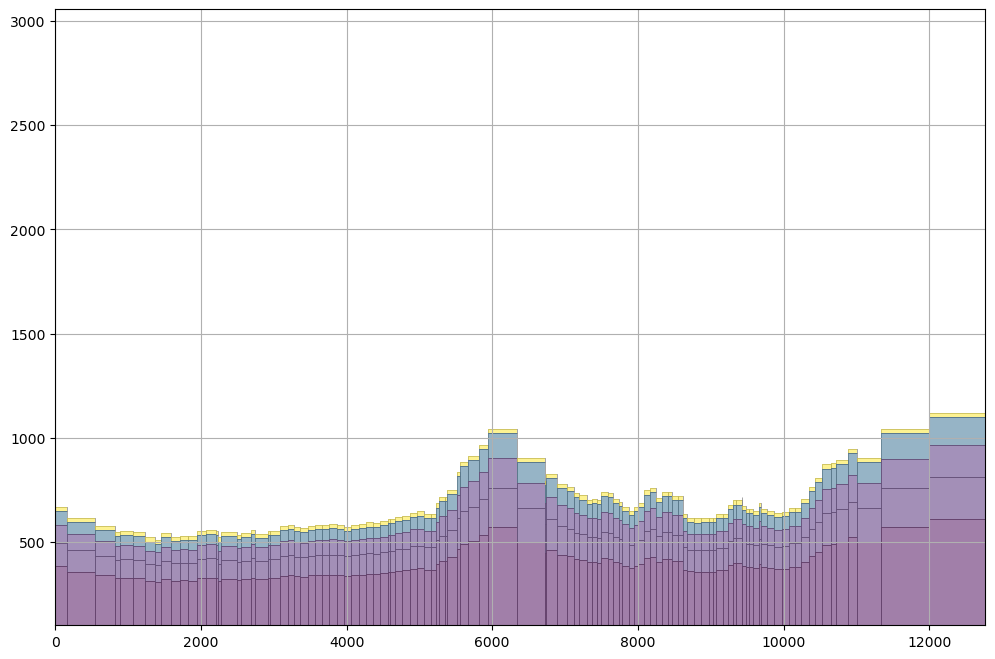

In [13]:
## <==== inserted
crossSection = gpd.read_file('../shp/crossSection.shp') ## <==== inserted
sectionLine =list(crossSection.iloc[0].geometry.coords) ## <==== inserted

fig, ax = plt.subplots(figsize=(12,8)) ## <==== inserted
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## <==== inserted
linecollection = modelxsect.plot_grid(lw=0.5) ## <==== inserted
modelxsect.plot_array(np.log(npf.k.array), alpha=0.5) ## <====== inserted
ax.grid() ## <==== inserted

In [14]:
# define storage and transient stress periods
sto = flopy.mf6.ModflowGwfsto(gwf, ## Org
                              iconvert=1, ## Org
                              steady_state={ ## Org
                                0:True, ## Org
                              } ## Org
                              ) ## Org

#### Working with rechage, evapotranspiration

In [15]:
rchr = 0.15/365/86400 ## Org
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rchr) ## Org
evtr = 1.2/365/86400 ## Org
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0) ## Org

### Definition of the intersect object
For the manipulation of spatial data to determine hydraulic parameters or boundary conditions

In [16]:
# Define intersection object
interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) ## Org

In [17]:
#open the river shapefile
rivers =gpd.read_file('../hatariUtils/river_basin.shp') ## <==== updated
list_rivers=[] ## Org
for i in range(rivers.shape[0]): ## Org
    list_rivers.append(rivers['geometry'].loc[i]) ## Org
    
riverMls = MultiLineString(lines=list_rivers) ## Org

#intersec rivers with our grid
riverCells=interIx.intersect(riverMls).cellids ## Org
riverCells[:10] ## Org

array([252, 275, 291, 321, 336, 344, 370, 434, 441, 446], dtype=object)

In [18]:
#river package
riverSpd = {} ## Org
riverSpd[0] = [] ## Org
for cell in riverCells: ## Org
    riverSpd[0].append([(0,cell),mtop[cell],0.01]) ## Org
riv = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=riverSpd) ## Org

[<Axes: title={'center': ' drn_0 location stress period 1 layer 1'}>]

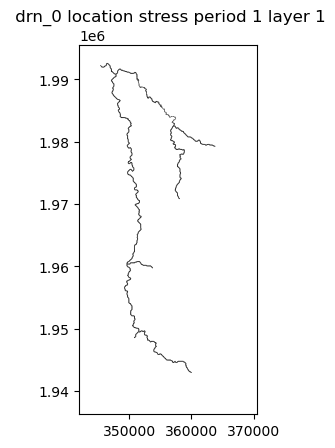

In [19]:
#river plot
riv.plot(mflay=0) ## Org

### Set the Output Control and run simulation

In [20]:
#oc
head_filerecord = f"{gwf.name}.hds" ## Org
budget_filerecord = f"{gwf.name}.cbc" ## Org
oc = flopy.mf6.ModflowGwfoc(gwf, ## Org
                            head_filerecord=head_filerecord, ## Org
                            budget_filerecord = budget_filerecord, ## Org
                            saverecord=[("HEAD", "LAST"),("BUDGET","LAST")]) ## Org

In [21]:
# Run the simulation
sim.write_simulation() ## Org
success, buff = sim.run_simulation() ## Org

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6Model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package evta_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 929 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

   MODFLOW 6 compiled Dec 31 2024 17:10:16 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for rel

### Model output visualization

In [22]:
headObj = gwf.output.head() ## Org
headObj.get_kstpkper() ## Org

[(0, 0)]

In [23]:
heads = headObj.get_data() ## Org
heads[2,0,:5] ## Org

array([1016.74658849, 1003.30308189, 1016.19148927, 1015.36206045,
       1017.46065387])

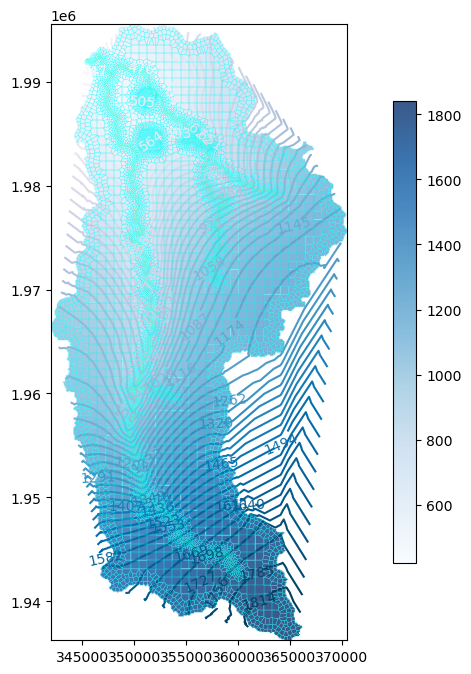

In [24]:
# Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(12,8)) ## Org
ax = fig.add_subplot(1, 1, 1, aspect='equal') ## Org
modelmap = flopy.plot.PlotMapView(model=gwf) ## Org

####
levels = np.linspace(heads[heads>-1e+30].min(),heads[heads>-1e+30].max(),num=50) ## Org
contour = modelmap.contour_array(heads[3],ax=ax,levels=levels,cmap='PuBu') ## Org
ax.clabel(contour) ## Org


quadmesh = modelmap.plot_bc('DRN') ## Org
cellhead = modelmap.plot_array(heads[3],ax=ax, cmap='Blues', alpha=0.8) ## Org

linecollection = modelmap.plot_grid(linewidth=0.3, alpha=0.5, color='cyan', ax=ax) ## Org

plt.colorbar(cellhead, shrink=0.75) ## Org

plt.show() ## Org

In [26]:
from mf6Voronoi.tools.graphs2d import generateRasterFromArray ## <==== updated
waterTable = flopy.utils.postprocessing.get_water_table(heads)
generateRasterFromArray(gwf, 
                        waterTable,
                        meshLayer='../output/mineRegional.shp', 
                        rasterRes=10, 
                        epsg=32614, 
                        outputPath='../output/waterTable.tif')

Raster X Dim: 28500.00, Raster Y Dim: 59300.00
Number of cols:  2851, Number of rows: 5931
